In [129]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

## Part 1 ‐ Exploratory data analysis

In [63]:
# Load the data
df = pd.read_json('logins.json')

In [64]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [65]:
df.describe()

<ipython-input-65-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [51]:
# Check for missing values
df.isna().sum()

login_time    0
dtype: int64

In [53]:
#Check for duplicates
df.duplicated().sum()

877

In [72]:
#Not sure if it is duplicates or just different users logged in at the same time. So won't delete the duplicates.

In [55]:
# Ensure datetime format for timestamps
df['login_time'] = pd.to_datetime(df['login_time'])
df.set_index('login_time', inplace=True)

In [56]:
df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [57]:
# Resample data in 15-minute intervals and calculate login counts
login_counts = df.resample('15T').size().reset_index()
login_counts.columns = ['login_time', 'login_count']

In [58]:
login_counts

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


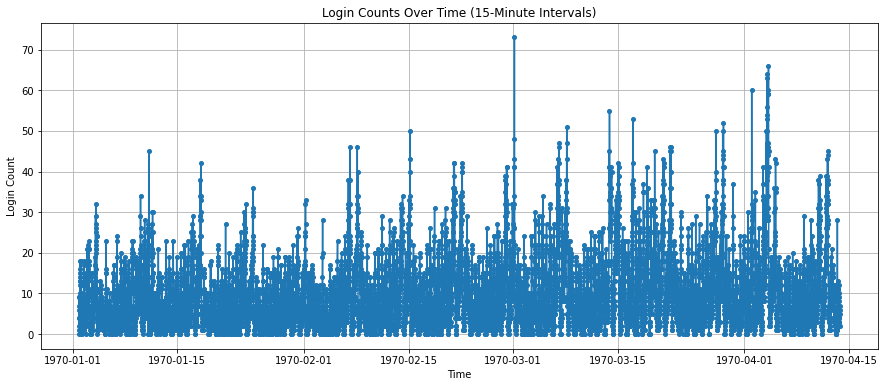

In [59]:
# Visualize login counts over time
plt.figure(figsize=(15, 6))
plt.plot(login_counts['login_time'], login_counts['login_count'], marker='o', markersize=4, linestyle='-')
plt.title('Login Counts Over Time (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.grid(True)
plt.show()

In [60]:
# Create additional time-related features
login_counts['hour'] = login_counts['login_time'].dt.hour
login_counts['day_of_week'] = login_counts['login_time'].dt.dayofweek
login_counts['month'] = login_counts['login_time'].dt.month

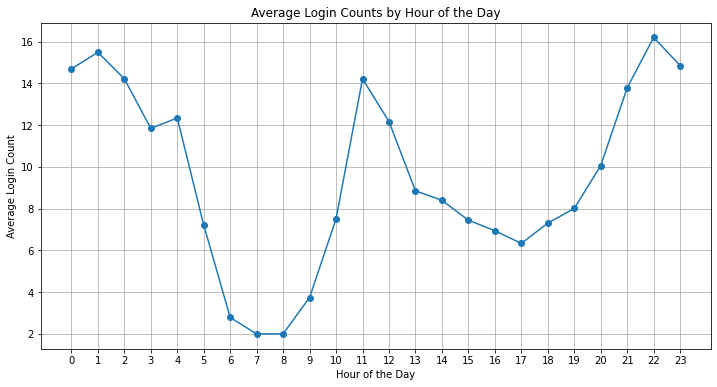

In [61]:
# Visualize daily login patterns
daily_login = login_counts.groupby('hour')['login_count'].mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_login.index, daily_login.values, marker='o', markersize=6, linestyle='-')
plt.title('Average Login Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Login Count')
plt.grid(True)
plt.xticks(np.arange(24))
plt.show()

## Part 2 ‐ Experiment and metrics design

#### Key Measure of Success:

The key metric is the increase in the number of driver partners who cross between the cities during weekdays. This metric reflects the success of reducing exclusivity and promoting cross-city operation.

#### Experimental Design:

**Randomized Experiment**: We would randomly select a group of driver partners and offer to reimburse their toll costs for a specified duration.

**Control Group**: A control group consisting of driver partners who do not receive toll reimbursements will be maintained. This group provides a baseline for comparison.

**Duration**: The experiment would run for a sufficient duration to capture weekday patterns effectively, such as one month.

#### Implementation:

During the experiment, the following steps will be implemented:

Identify driver partners willing to participate in the experiment.

Randomly assign driver partners to either the toll reimbursement group (experimental) or the non-reimbursement group (control).

Reimburse the toll costs for the experimental group.

Monitor and record the daily activities of driver partners in both groups, focusing on weekday operations.

Ensure data collection for both cities separately.

#### Statistical Tests:

To verify the significance of the observation, we would perform statistical tests, such as a t-test or chi-squared test, to compare the weekday activity patterns between the experimental and control groups. Specifically, we would test whether the number of driver partners crossing between the cities during weekdays is significantly higher in the experimental group compared to the control group.

#### Interpretation of Results and Recommendations:

If the experimental group shows a statistically significant increase in cross-city operation during weekdays compared to the control group, this suggests that reimbursing toll costs is effective.
If the results are statistically insignificant, the experiment might not be effective, and other strategies should be explored.

#### Caveats:

External factors like weather, holidays, or special events could influence driver behavior and should be considered.
The willingness of driver partners to participate in the experiment may vary, potentially affecting the sample size.

## Part 3 ‐ Predictive modeling

In [74]:
# Load the data
df = pd.read_json('ultimate_data_challenge.json')

In [75]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [70]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [71]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [77]:
# Data Cleaning
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [83]:
#Create new column 'retained'(took a trip in the preceding 30 days before the last trip date), 
#which will be the target variable
df['retained'] = (df['last_trip_date'].max() - df['last_trip_date']).dt.days <= 30

In [84]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,True
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,False
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,False
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,False


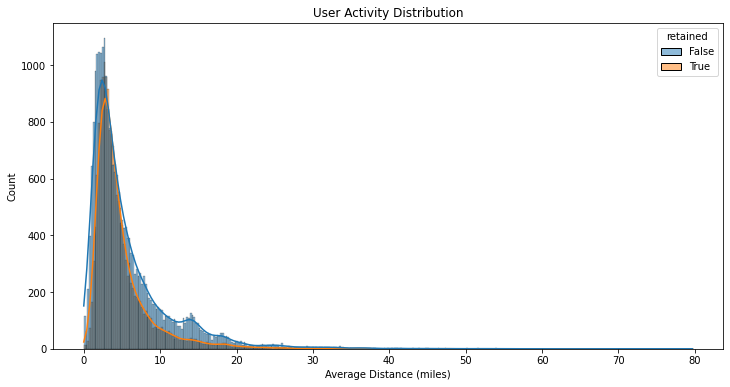

In [127]:
# User Activity Distribution (e.g., avg_dist)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='avg_dist', hue='retained', kde=True)
plt.xlabel('Average Distance (miles)')
plt.title('User Activity Distribution')
plt.show()

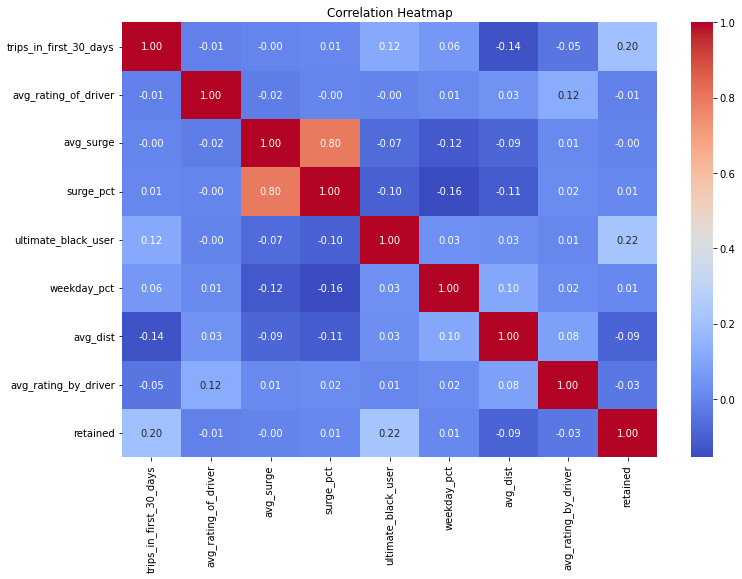

In [128]:
# Correlation Heatmap
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [102]:
#Drop rows with missing values
df = df.dropna()

In [103]:
# Define features and target variable
X = df.drop(['last_trip_date', 'retained'], axis=1)
y = df['retained']

In [104]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [105]:
#Convert datetime to timestamp to be able to work with Random Forest Classifier
X['signup_date'] = X['signup_date'].values.astype(np.int64) 

In [106]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# Build a Random Forest Classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [108]:
# Make predictions
y_pred = model.predict(X_test)

In [109]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [110]:
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.7570273856918808
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80      4823
        True       0.73      0.67      0.70      3466

    accuracy                           0.76      8289
   macro avg       0.75      0.74      0.75      8289
weighted avg       0.76      0.76      0.76      8289



In [112]:
# Get feature importances
feature_importances = model.feature_importances_

In [116]:
# Create a list of feature names 
feature_names = X_train.columns

In [117]:
# Combine feature names with their corresponding importances and sort by importance
feature_ranking = list(zip(feature_names, feature_importances))
feature_ranking.sort(key=lambda x: x[1], reverse=True)

In [118]:
# Print the feature ranking
print("Feature ranking:")
for rank, (feature, importance) in enumerate(feature_ranking, start=1):
    print(f"{rank}. {feature}: {importance}")

Feature ranking:
1. avg_dist: 0.19437962415574656
2. signup_date: 0.13032795656113272
3. weekday_pct: 0.12520692596726482
4. avg_rating_by_driver: 0.11624146394083759
5. surge_pct: 0.07832962625576555
6. trips_in_first_30_days: 0.07430967713065934
7. avg_rating_of_driver: 0.06924001151768015
8. avg_surge: 0.06330659077395255
9. city_King's Landing: 0.061484187935831096
10. phone_iPhone: 0.03614885019192642
11. ultimate_black_user_True: 0.03458638575054477
12. city_Winterfell: 0.01643869981865849


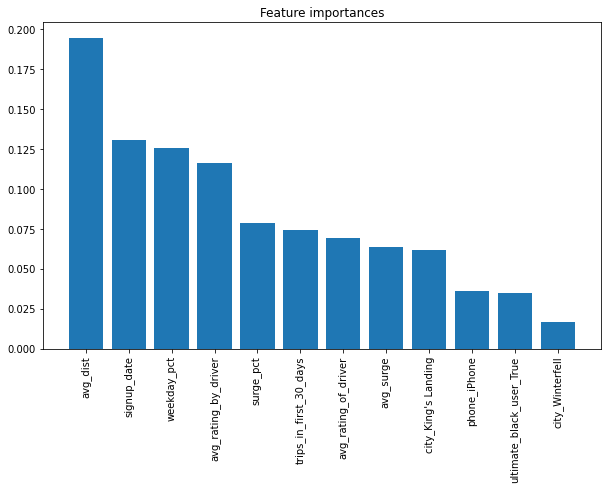

In [119]:
#Visualize feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(feature_ranking)), [importance for (_, importance) in feature_ranking], align="center")
plt.xticks(range(len(feature_ranking)), [feature for (feature, _) in feature_ranking], rotation=90)
plt.xlim([-1, len(feature_ranking)])
plt.show()

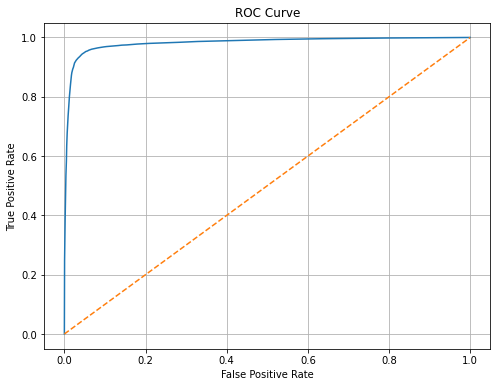

In [130]:
#ROC Curve
y_pred_proba = model.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

**Model Choice**: I chose a Random Forest Classifier as it can handle both numerical and categorical features, is robust to overfitting, and can provide feature importances.

**Model Performance**: The accuracy and classification report provide insights into how well the model predicts user retention. Further optimization and feature engineering can be performed to improve model performance.

**Leveraging Insights**: Ultimate can leverage insights gained from the model to identify the most influential factors affecting rider retention. Strategies can be developed to target these factors and improve long-term rider retention, such as enhancing the user experience for riders with low ratings or incentivizing Ultimate Black usage.